In [3]:
!pip install albumentations==0.4.6

In [4]:
import os
import torch
import tqdm
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms.functional as TF
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

In [5]:
torch.cuda.get_device_name()

'Tesla T4'

In [6]:
class LoadDataset(Dataset):
    def __init__(self, img_dir, msk_dir, transform=None):
        self.img_dir = img_dir
        self.msk_dir = msk_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images[index])
        msk_path = os.path.join(self.msk_dir, self.images[index].replace(".jpg", "_mask.gif"))

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(msk_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [7]:
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 16
epochs = 10
img_height = 160  
img_width = 240  
train_img_dir = "sample_train/"
train_mask_dir= "sample_train_masks/"
val_img_dir = "sample_train/"
val_mask_dir = "sample_train_masks/"

In [8]:
device

'cuda'

In [9]:
train_transform = A.Compose([A.Resize(height=img_height, width=img_width), 
                             A.Rotate(limit=35, p=1.0), 
                             A.HorizontalFlip(p=0.5), 
                             A.VerticalFlip(p=0.1),
                             A.Normalize(mean=[0.0, 0.0, 0.0],
                                         std=[1.0, 1.0, 1.0],
                                         max_pixel_value=255.0),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(height=img_height, width=img_width), 
                           A.Normalize(mean=[0.0, 0.0, 0.0],
                                       std=[1.0, 1.0, 1.0], 
                                       max_pixel_value=255.0),
                           ToTensorV2()])

In [10]:
train_data = LoadDataset(img_dir=train_img_dir, msk_dir=train_mask_dir, transform=train_transform)
val_data = LoadDataset(img_dir=val_img_dir, msk_dir=val_mask_dir, transform=val_transform)    

In [11]:
len(train_data), len(val_data)

(160, 160)

In [12]:
train_batches = DataLoader(train_data, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)
val_batches = DataLoader(val_data, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=False)

In [13]:
img, msk = train_data[42]
img.shape, msk.shape

(torch.Size([3, 160, 240]), torch.Size([160, 240]))

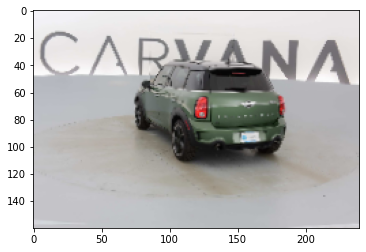

In [14]:
plt.imshow(img.permute(1, 2, 0))

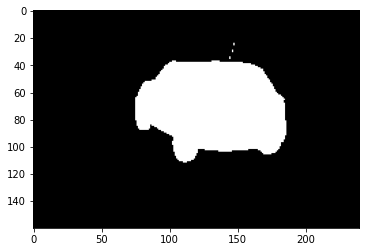

In [15]:
plt.imshow(msk, cmap="gray")

In [16]:
for X, y in train_batches:
    print(X.shape)
    print(y.shape)
    break

torch.Size([16, 3, 160, 240])
torch.Size([16, 160, 240])


In [17]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
                                  nn.BatchNorm2d(out_channels), 
                                  nn.ReLU(inplace=True), 
                                  nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False), 
                                  nn.BatchNorm2d(out_channels), 
                                  nn.ReLU(inplace=True))
        
    def forward(self, x):
        return self.conv(x)

In [18]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        for f in features:
            self.downs.append(DoubleConv(in_channels, f))
            in_channels = f

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for f in reversed(features):
            self.ups.append(nn.ConvTranspose2d(f * 2, f, 2, 2))
            self.ups.append(DoubleConv(f * 2, f))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for d in self.downs:
            x = d(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            sc = skip_connections[i // 2]

            if x.shape != sc.shape:
                x = TF.resize(x, size=sc.shape[2:])

            scx = torch.cat((sc, x), dim=1)
            x = self.ups[i + 1](scx)

        return self.final_conv(x)

In [19]:
net = UNET().to(device)

In [20]:
x = train_data[42][0].unsqueeze(0).to(device)
y = net(x)
x.shape, y.shape

(torch.Size([1, 3, 160, 240]), torch.Size([1, 1, 160, 240]))

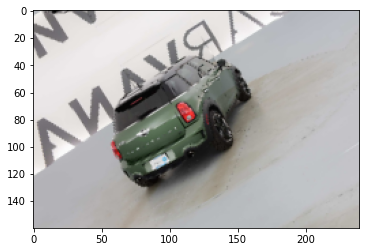

In [21]:
plt.imshow(x[0].permute(1, 2, 0).cpu())

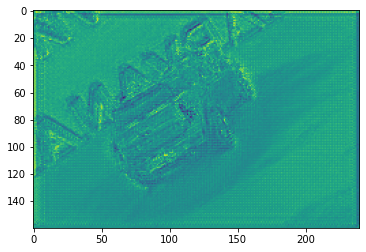

In [22]:
plt.imshow(y[0, 0, :, :].detach().cpu())

In [23]:
def get_accuracy(preds, y):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    
    num_correct += (preds == y).sum()
    num_pixels += torch.numel(y)
    dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    return num_correct / num_pixels, dice_score

In [24]:
def save_images(preds, y, epoch):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    torchvision.utils.save_image(preds, f"predictions/pred_{epoch}.png")
    torchvision.utils.save_image(y, f"ground_truths/gt_{epoch}.png")

    print("Images Saved!")
    print("")

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(net.parameters(), lr)
scaler = torch.cuda.amp.GradScaler()

In [26]:
def loop(batches, net, epoch, train):
    batch_losses = []
    batch_accs = []
    dice_scores = []

    if train:
        print("Train Loop:")
        print("")
        net.train()

        for X, y in tqdm.tqdm(batches, total=len(batches)):
            X = X.to(device)
            y = y.float().unsqueeze(1).to(device)

            with torch.cuda.amp.autocast():
                preds = net(X)
                loss = loss_fn(preds, y)            
                acc, ds = get_accuracy(preds, y)

            opt.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            batch_losses.append(loss.item())
            batch_accs.append(acc) 
            dice_scores.append(ds)

    else:
        print("Validation Loop:")
        print("")
        net.eval()

        with torch.no_grad():
            for X, y in tqdm.tqdm(batches, total=len(batches)):
                X = X.to(device)
                y = y.float().unsqueeze(1).to(device)

                preds = net(X)
                loss = loss_fn(preds, y)
                acc, ds = get_accuracy(preds, y)

                batch_losses.append(loss.item())
                batch_accs.append(acc) 
                dice_scores.append(ds)
            
        save_images(preds, y, epoch)

    print("")
    print("")

    return sum(batch_losses) / len(batch_losses), sum(batch_accs) / len(batch_accs), sum(dice_scores) / len(dice_scores)

In [27]:
for epoch in range(epochs):
    train_loss, train_acc, train_dice_score = loop(train_batches, net, epoch, True)
    val_loss, val_acc, val_dice_score = loop(val_batches, net, epoch, False)

    print(f"epoch: {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | train_dice_score: {train_dice_score:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f} | val_dice_score: {val_dice_score:.4f}")
    print("")

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/10 [00:00<?, ?it/s]

Images Saved!



epoch: 0 | train_loss: 0.5883 | train_acc: 0.7359 | train_dice_score: 0.6214 | val_loss: 0.6513 | val_acc: 0.7778 | val_dice_score: 0.0000

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/10 [00:00<?, ?it/s]

Images Saved!



epoch: 1 | train_loss: 0.3865 | train_acc: 0.9248 | train_dice_score: 0.8509 | val_loss: 0.5830 | val_acc: 0.7778 | val_dice_score: 0.0000

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/10 [00:00<?, ?it/s]

Images Saved!



epoch: 2 | train_loss: 0.3056 | train_acc: 0.9663 | train_dice_score: 0.9273 | val_loss: 0.5281 | val_acc: 0.7778 | val_dice_score: 0.0001

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/10 [00:00<?, ?it/s]

Images Saved!



epoch: 3 | train_loss: 0.2755 | train_acc: 0.9728 | train_dice_score: 0.9405 | val_loss: 0.4002 | val_acc: 0.8870 | val_dice_score: 0.6566

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/10 [00:00<?, ?it/s]

Images Saved!



epoch: 4 | train_loss: 0.2608 | train_acc: 0.9756 | train_dice_score: 0.9459 | val_loss: 0.2878 | val_acc: 0.9669 | val_dice_score: 0.9211

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/10 [00:00<?, ?it/s]

Images Saved!



epoch: 5 | train_loss: 0.2476 | train_acc: 0.9790 | train_dice_score: 0.9535 | val_loss: 0.2476 | val_acc: 0.9825 | val_dice_score: 0.9617

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/10 [00:00<?, ?it/s]

Images Saved!



epoch: 6 | train_loss: 0.2367 | train_acc: 0.9817 | train_dice_score: 0.9594 | val_loss: 0.2276 | val_acc: 0.9860 | val_dice_score: 0.9691

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/10 [00:00<?, ?it/s]

Images Saved!



epoch: 7 | train_loss: 0.2310 | train_acc: 0.9819 | train_dice_score: 0.9600 | val_loss: 0.2246 | val_acc: 0.9825 | val_dice_score: 0.9608

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



  0%|          | 0/10 [00:00<?, ?it/s]

Images Saved!



epoch: 8 | train_loss: 0.2263 | train_acc: 0.9826 | train_dice_score: 0.9612 | val_loss: 0.2155 | val_acc: 0.9876 | val_dice_score: 0.9723

Train Loop:



  0%|          | 0/10 [00:00<?, ?it/s]



Validation Loop:



100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Images Saved!



epoch: 9 | train_loss: 0.2186 | train_acc: 0.9846 | train_dice_score: 0.9658 | val_loss: 0.2119 | val_acc: 0.9852 | val_dice_score: 0.9676

